# Assignment 4 #

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized. The distances between nodes are calculated as Euclidean distances rounded mathematically to integer values. The distance matrix should be calculated just after reading an instance and then only the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow instances defined only by distance matrices. 

## Read the data ##

In [1]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from math import sqrt
from typing import List, Optional, Tuple, Union 

In [2]:
# read data into dataframes
instances = {
    "A": pd.read_csv("data/TSPA.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "B": pd.read_csv("data/TSPB.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "C": pd.read_csv("data/TSPC.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "D": pd.read_csv("data/TSPD.csv", sep=';', header=None, names=["x", "y", "cost"]),
}

In [3]:
def calculate_distance_matrix(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer + the cost of the destination node.
    """
    coordinates = df[['x', 'y']].to_numpy()
    dist_matrix = np.zeros(shape=(len(df), len(df)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist_matrix[i, j] = round(sqrt((coordinates[i, 0] - coordinates[j, 0])**2 + (coordinates[i, 1] - coordinates[j, 1])**2))
    return dist_matrix

In [4]:
def calculate_nearest_vertices(dist_matrix: np.ndarray, costs: np.ndarray, num_candidates: int = 10) -> list:
    num_vertices = dist_matrix.shape[0]
    nearest_vertices = []

    for i in range(num_vertices):
        cost_distance_sum = dist_matrix[i, :] + costs
        sorted_vertices = np.argsort(cost_distance_sum)
        nearest_vertices.append([vertex for vertex in sorted_vertices if vertex != i][:num_candidates])

    return nearest_vertices

In [5]:
distances_matrices = {
    "A": calculate_distance_matrix(instances["A"]),
    "B": calculate_distance_matrix(instances["B"]),
    "C": calculate_distance_matrix(instances["C"]),
    "D": calculate_distance_matrix(instances["D"])
}

costs = {
    "A": instances["A"]["cost"].to_numpy(),
    "B": instances["B"]["cost"].to_numpy(),
    "C": instances["C"]["cost"].to_numpy(),
    "D": instances["D"]["cost"].to_numpy()
}

nearest_vertices = {
    "A": calculate_nearest_vertices(distances_matrices["A"], costs["A"]),
    "B": calculate_nearest_vertices(distances_matrices["B"], costs["B"]),
    "C": calculate_nearest_vertices(distances_matrices["C"], costs["C"]),
    "D": calculate_nearest_vertices(distances_matrices["D"], costs["D"])
}

In [6]:
def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame,
    title: str) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.

    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    """
    x = dataframe["x"].to_numpy()
    y = dataframe["y"].to_numpy()
    costs = dataframe["cost"].to_numpy()

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    plt.colorbar(scatter, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    plt.title(title, fontsize=18)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(True)
    plt.show()

In [7]:
def objective_function(solution: list[int], dist_matrix: list[list[int]], costs: list[int]) -> int:
    total_score = 0
    n = len(solution)
    for x in range(n):
        total_score += dist_matrix[solution[x - 1]][solution[x]]
        total_score += costs[solution[x]]
    return total_score

In [8]:
# A function that generates a random solution
def generate_random_solution(n: int) -> list[int]:
    """
    Generate a random solution for a given number of nodes.

    :param n: The number of nodes.
    :return: A list of nodes representing the solution.
    """
    return random.sample(range(0, n * 2), n)

In [60]:
# This it the old function that need to be debugged
# Sometimes the second solution is not generated correctly (it is the same as the first solution)
# and the delta is not calculated correctly
def two_edges_exchange(current_solution: list[int], 
                       nearest_vertices: list[list[int]],
                       score,
                       distance_matrix,
                       cost) -> list[list[int]]:
    """
    Generate new solutions by exchanging two edges in the current solution.

    :param current_solution: List of nodes in the current solution.
    :param current_score: The score of the current solution.
    :param distance_matrix: 2D list representing the distances between nodes.
    :return: A list of tuples where each tuple contains a new solution and its score.
    """
    n = len(current_solution)
    new_solutions = []

    for i in range(n):
        node1 = current_solution[i]
        node1_index = i
        node2_candidates = nearest_vertices[node1]
        
        for node2 in node2_candidates:
            node1_index = i
            if node2 in current_solution:
                node2_index = current_solution.index(node2)

                if node2_index < node1_index:
                    node1_index, node2_index = node2_index, node1_index
                if (node2_index - node1_index) % n > 1 and (node1_index - node2_index) % n > 1:
                    print("********************")
                    print(f"Difference: {(node2_index - node1_index) % n}")                    
                    print(f"INDEX CHECKS: {current_solution[node1_index]}, {current_solution[node2_index]}")
                    
                    new_solution1 = (current_solution[:node1_index] 
                                    + current_solution[node1_index :node2_index][::-1] 
                                    + current_solution[node2_index  :])
                    added_edge_1 = distance_matrix[new_solution1[node1_index-1]][new_solution1[node1_index]]
                    added_edge_2 = distance_matrix[new_solution1[node2_index-1]][new_solution1[node2_index]]
                    removed_edge_1 = distance_matrix[current_solution[node1_index-1]][current_solution[node1_index]]
                    removed_edge_2 = distance_matrix[new_solution1[node1_index]][new_solution1[node2_index]]
                    new_solution1_score = score + added_edge_1 + added_edge_2 - removed_edge_2 - removed_edge_1
                    new_solutions.append((new_solution1, new_solution1_score))
                    print("##############")
                    print(f"Inserting edge: ({node1}->{node2})")
                    print("Solution 1")
                    print(f"Segment 1: {current_solution[:node1_index]}")
                    print(f"Segment 2: {current_solution[node1_index :node2_index][::-1]}")
                    print(f"Segment 3: {current_solution[node2_index  :]}")
                    print(f"Old solution: {current_solution} New solution: {new_solution1}")
                    print(f"Removed edges: ({current_solution[node1_index-1]}->{current_solution[node1_index]}), ({new_solution1[node1_index]}->{new_solution1[node2_index]})")
                    print(f"Added edges: ({new_solution1[node1_index-1]}->{new_solution1[node1_index]}), ({new_solution1[node2_index-1]}->{new_solution1[node2_index]})")
                    
                    # second solution
                    new_solution2 = (current_solution[:node1_index + 1] 
                                    + current_solution[node2_index:] 
                                    + current_solution[node1_index + 1:node2_index][::-1])
                    removed_edge_1 = distance_matrix[current_solution[node1_index]][current_solution[(node1_index + 1)%n]]
                    removed_edge_2 = distance_matrix[current_solution[node2_index]][current_solution[(node2_index+1)%n]]
                    
                    added_edge_1 = distance_matrix[current_solution[node1_index]][current_solution[node2_index]]
                    added_edge_2 = distance_matrix[current_solution[(node1_index + 1)%n]][current_solution[(node2_index+1)%n]]
                    print("##############")
                    print(f"Inserting edge: ({node1}->{node2})")
                    print("Solution 2")
                    print(f"Segment 1: {current_solution[:node1_index + 1]}")
                    print(f"Segment 2: {current_solution[node2_index:]}")
                    print(f"Segment 3: {current_solution[node1_index + 1:node2_index][::-1]}")
                    print(f"Old solution: {current_solution} New solution: {new_solution2}")
                    print(f"Removed edges: ({current_solution[len(current_solution[:node1_index + 1])-1]}->{current_solution[len(current_solution[:node1_index + 1])]}), ({current_solution[node2_index-1]}->{current_solution[node2_index]})")
                    print(f"Added edges: ({current_solution[node1_index]}->{current_solution[node2_index]}), ({current_solution[node2_index:][-1]}->{current_solution[node1_index + 1:node2_index][::-1][0]})")
                    new_solution2_score = score + added_edge_1 + added_edge_2 - removed_edge_2 - removed_edge_1
                    new_solutions.append((new_solution2, new_solution2_score))
    
    return new_solutions

In [81]:
import numpy as np
# Here is more proper method. It correctly calculates the delta for both solutions.
# The only problem is that sometimes the second solution is not generated correctly (it is the same as the original solution)
def two_edges_exchange(current_solution: list[int], 
                       nearest_vertices: list[list[int]],
                       score,
                       distance_matrix,
                       ) -> list[list[int]]:
    n = len(current_solution)
    new_solutions = []

    for i in range(n):
        node1 = current_solution[i]
        for node2 in nearest_vertices[node1]:
            if node2 in current_solution:
                node2_index = current_solution.index(node2)

                # Make sure node1_index is less than node2_index
                if node2_index < i:
                    node1_index, node2_index = node2_index, i
                else:
                    node1_index = i
                
                # Check if nodes are not adjacent (considering wraparound)
                if (node2_index - node1_index) % n > 1 and (node1_index - node2_index + n) % n > 1:
                    print("********************")
                    # First solution
                    new_solution1 = (current_solution[:node1_index] 
                                    + current_solution[node1_index:node2_index][::-1] 
                                    + current_solution[node2_index:])
                    
                    # Distance calculation for new_solution1
                    added_edge_1 = distance_matrix[new_solution1[node1_index-1]][new_solution1[node1_index]]
                    added_edge_2 = distance_matrix[new_solution1[node2_index-1]][new_solution1[node2_index % n]]
                    removed_edge_1 = distance_matrix[current_solution[node1_index-1]][current_solution[node1_index]]
                    removed_edge_2 = distance_matrix[current_solution[(node2_index-1+n) % n]][current_solution[node2_index]]
                    new_solution1_score = score + added_edge_1 + added_edge_2 - removed_edge_1 - removed_edge_2
                    new_solutions.append((new_solution1, new_solution1_score))
                    print("##############")
                    print(f"Inserting edge: ({node1}->{node2})")
                    print("Solution 1")
                    print(f"Segment 1: {current_solution[:node1_index]}")
                    print(f"Segment 2: {current_solution[node1_index :node2_index][::-1]}")
                    print(f"Segment 3: {current_solution[node2_index  :]}")
                    print(f"Old solution: {current_solution} New solution: {new_solution1}")
                    print(f"Removed edges: ({current_solution[node1_index-1]}->{current_solution[node1_index]}), ({current_solution[(node2_index-1+n) % n]}->{current_solution[node2_index]})")
                    print(f"Added edges: ({new_solution1[node1_index-1]}->{new_solution1[node1_index]}), ({new_solution1[node2_index-1]}->{new_solution1[node2_index%n]})")
                    # Second solution
                    # This should take the segment after node2_index to the end, and the segment from node1_index+1 to node2_index, and reverse it
                    # Then append it to the part from the start to node1_index+1
                    second_segment_reversed = current_solution[node1_index+1:node2_index][::-1]
                    new_solution2 = current_solution[:node1_index+1] + second_segment_reversed + current_solution[node2_index:]

                    # Now calculate the distances for the new edges and subtract the distances of the removed edges.
                    removed_edge_1 = distance_matrix[current_solution[node1_index]][current_solution[(node1_index+1) % n]]
                    removed_edge_2 = distance_matrix[current_solution[node2_index-1]][current_solution[node2_index]]
                    added_edge_1 = distance_matrix[current_solution[node1_index]][current_solution[node2_index-1]]
                    added_edge_2 = distance_matrix[current_solution[(node1_index+1) % n]][current_solution[node2_index]]
                    new_solution2_score = score + added_edge_1 + added_edge_2 - removed_edge_1 - removed_edge_2
                    print("##############")
                    print("Solution 2")
                    print(f"Segment 1: {current_solution[:node1_index+1]}")
                    print(f"Segment 2: {second_segment_reversed}")
                    print(f"Segment 3: {current_solution[node2_index:]}")
                    print(f"Old solution: {current_solution} New solution: {new_solution2}")
                    print(f"Removed edges: ({current_solution[node1_index]}->{current_solution[(node1_index+1)%n]}), ({current_solution[node2_index-1]}->{current_solution[node2_index]})")
                    print(f"Added edges: ({current_solution[node1_index]}->{current_solution[node2_index-1]}), ({current_solution[(node1_index+1) % n]}->{current_solution[node2_index]})")
                    new_solutions.append((new_solution2, new_solution2_score))
    
    return new_solutions


In [82]:
sol = [2,7,4,6,1,5,3,8,0]
nearest_vertices = [
    [1,2,3,4,5,6,7,8],[0,2,3,4,5,6,7,8],[0,1,3,4,5,6,7,8],[0,1,2,4,5,6,7,8],[0,1,2,3,5,6,7,8],[0,1,2,3,4,6,7,8],[0,1,2,3,4,5,7,8],[0,1,2,3,4,5,6,8],[1,2,3,4,5,6,7]
]
score=0 
dis=list(np.random.randint(1,10,(9,9)))
two_edges_exchange(sol, nearest_vertices, score, dis)

********************
##############
Inserting edge: (2->1)
Solution 1
Segment 1: []
Segment 2: [6, 4, 7, 2]
Segment 3: [1, 5, 3, 8, 0]
Old solution: [2, 7, 4, 6, 1, 5, 3, 8, 0] New solution: [6, 4, 7, 2, 1, 5, 3, 8, 0]
Removed edges: (0->2), (6->1)
Added edges: (0->6), (2->1)
##############
Solution 2
Segment 1: [2]
Segment 2: [6, 4, 7]
Segment 3: [1, 5, 3, 8, 0]
Old solution: [2, 7, 4, 6, 1, 5, 3, 8, 0] New solution: [2, 6, 4, 7, 1, 5, 3, 8, 0]
Removed edges: (2->7), (6->1)
Added edges: (2->6), (7->1)
********************
##############
Inserting edge: (2->3)
Solution 1
Segment 1: []
Segment 2: [5, 1, 6, 4, 7, 2]
Segment 3: [3, 8, 0]
Old solution: [2, 7, 4, 6, 1, 5, 3, 8, 0] New solution: [5, 1, 6, 4, 7, 2, 3, 8, 0]
Removed edges: (0->2), (5->3)
Added edges: (0->5), (2->3)
##############
Solution 2
Segment 1: [2]
Segment 2: [5, 1, 6, 4, 7]
Segment 3: [3, 8, 0]
Old solution: [2, 7, 4, 6, 1, 5, 3, 8, 0] New solution: [2, 5, 1, 6, 4, 7, 3, 8, 0]
Removed edges: (2->7), (5->3)
Added edges:

[([6, 4, 7, 2, 1, 5, 3, 8, 0], 1),
 ([2, 6, 4, 7, 1, 5, 3, 8, 0], 6),
 ([5, 1, 6, 4, 7, 2, 3, 8, 0], -3),
 ([2, 5, 1, 6, 4, 7, 3, 8, 0], -1),
 ([7, 2, 4, 6, 1, 5, 3, 8, 0], 8),
 ([2, 7, 4, 6, 1, 5, 3, 8, 0], 0),
 ([1, 6, 4, 7, 2, 5, 3, 8, 0], -2),
 ([2, 1, 6, 4, 7, 5, 3, 8, 0], -2),
 ([4, 7, 2, 6, 1, 5, 3, 8, 0], -3),
 ([2, 4, 7, 6, 1, 5, 3, 8, 0], 0),
 ([3, 5, 1, 6, 4, 7, 2, 8, 0], -4),
 ([2, 3, 5, 1, 6, 4, 7, 8, 0], -4),
 ([2, 8, 3, 5, 1, 6, 4, 7, 0], 2),
 ([2, 7, 8, 3, 5, 1, 6, 4, 0], 5),
 ([2, 6, 4, 7, 1, 5, 3, 8, 0], 6),
 ([2, 7, 6, 4, 1, 5, 3, 8, 0], 7),
 ([2, 5, 1, 6, 4, 7, 3, 8, 0], -1),
 ([2, 7, 5, 1, 6, 4, 3, 8, 0], 6),
 ([2, 1, 6, 4, 7, 5, 3, 8, 0], -2),
 ([2, 7, 1, 6, 4, 5, 3, 8, 0], 4),
 ([2, 4, 7, 6, 1, 5, 3, 8, 0], 0),
 ([2, 7, 4, 6, 1, 5, 3, 8, 0], 0),
 ([2, 3, 5, 1, 6, 4, 7, 8, 0], -4),
 ([2, 7, 3, 5, 1, 6, 4, 8, 0], -4),
 ([2, 7, 8, 3, 5, 1, 6, 4, 0], 5),
 ([2, 7, 4, 8, 3, 5, 1, 6, 0], -5),
 ([2, 7, 6, 4, 1, 5, 3, 8, 0], 7),
 ([2, 7, 4, 6, 1, 5, 3, 8, 0], 0),
 ([7, 2,

In [78]:
def inter_route_exchange_simple(selected, unselected, score, distance_matrix, costs,  nearest_vertices):
    new_solutions = []

    # Assume node indices are 0-based for distance_matrix
    for selected_node in selected:
        for node in nearest_vertices[selected_node]:
            if node in unselected:
                new_solution1 = selected.copy()
                new_solution2 = selected.copy()
                replaced_node_index1= selected.index(selected_node)-1
                replaced_node_index2= selected.index(selected_node)+1

            
                # Assuming 'selected' and 'unselected' contain 0-based indices already
                new_solution1[replaced_node_index1] = node
                new_solution2[replaced_node_index2] = node

                prev_node_index1 = (replaced_node_index1 - 1) % len(selected)
                next_node_index1 = (replaced_node_index1 + 1) % len(selected)

                prev_node_index2 = (replaced_node_index2 - 1) % len(selected)
                next_node_index2 = (replaced_node_index2 + 1) % len(selected)

                # Calculate score_delta considering 0-based indices for distance_matrix
                score_delta1 = (
                    -distance_matrix[selected[prev_node_index1]][selected_node]
                    -distance_matrix[selected_node][selected[next_node_index1]]
                    +distance_matrix[selected[prev_node_index1]][node]
                    +distance_matrix[node][selected[next_node_index1]]
                    -costs[selected_node]
                    +costs[node]
                )
                score_delta2 = (
                    -distance_matrix[selected[prev_node_index2]][selected_node]
                    -distance_matrix[selected_node][selected[next_node_index2]]
                    +distance_matrix[selected[prev_node_index2]][node]
                    +distance_matrix[node][selected[next_node_index2]]
                    -costs[selected_node]
                    +costs[node]
                )
            new_score1 = score + score_delta1

            new_solutions.append((new_solution1, new_score1))
            new_score2= score + score_delta2

            new_solutions.append((new_solution2, new_score2))

    return new_solutions


In [79]:
sol = [ x for x in range (10)]
uns = [x for x in range (20,25)]
score=0 
dis=distances_matrices["A"]
cost=costs["A"]

nearest_vertics = [
    [23],[],[],[],[],[],[],[],[],[]
]
inter_route_exchange_simple(sol, uns, score, dis, cost,  nearest_vertics)

[([0, 1, 2, 3, 4, 5, 6, 7, 8, 23], 3646.0),
 ([0, 23, 2, 3, 4, 5, 6, 7, 8, 9], 3768.0)]

# Repository for Local Search solution finder #

In [9]:
from abc import ABC, abstractmethod
from typing import Union, Optional


class LocalSearch(ABC):
    """
    Abstract class for local search algorithms.
    """
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        """
        :param initial_solution: The initial solution.
        :param initial_score: The score of the initial solution.
        :param distance_matrix: 2D list representing the distances between nodes.
        """
        self.initial_solution = initial_solution
        self.initial_score = objective_function(initial_solution, distance_matrix, costs)
        self.distance_matrix = distance_matrix
        self.costs = costs
        
        self.all_nodes = list(range(100*2))
        self.unselected_nodes = [node for node in self.all_nodes if node not in self.initial_solution]
        
        self.current_solution: list[int] = initial_solution
        self.current_score = self.initial_score
        
        self.moves = {
            "intra-two-edges-exchange": self.two_edges_exchange,
            "intra-two-nodes-exchange": self.two_nodes_exchange,
            "inter-route-exchange": self.inter_route_exchange
        }
        
        self.moves_utils = {
            "intra-two-edges-exchange": self.get_utils_intra_two_edges_exchange,
            "intra-two-nodes-exchange": self.get_utils_intra_two_nodes_exchange,
            "inter-route-exchange": self.get_utils_inter_route_exchange
        }
       
    @abstractmethod
    def calculate_nearest_vertices(self):
        raise NotImplementedError
        
    @abstractmethod
    def get_utils_intra_two_edges_exchange(self):
        raise NotImplementedError
    
    @abstractmethod
    def get_utils_intra_two_nodes_exchange(self):
        raise NotImplementedError
    
    @abstractmethod
    def get_utils_inter_route_exchange(self):
        raise NotImplementedError

    # two method for intra moves
    @abstractmethod
    def two_edges_exchange(self, start_index: int = 0, direction: str = "right") -> Union[tuple[list[int], int], None]:
        """This method should return a new solution and its score if a better solution is found, otherwise None.
        For a greedy algorithm, the first better solution found should be returned. For a steepest local search,
        the best solution among all possible solutions should be returned, if there is no better solution, just
        return None. For a steepest local search, both neighborhood moves will return one solution, then we will
        take the better one among these two solutions.

        Parameters
        ----------
        current_solution : list[int]
        current_distance : int
        distance_matrix : list[list[int]]

        Returns
        -------
        tuple[list[int], int] | None
            A single better solution founded by the algorithm, or None if no better solution is found.
        """
        raise NotImplementedError
    
    @abstractmethod
    def two_nodes_exchange(self, start_index=0, direction='right') -> Union[tuple[list[int], int] , None]:
        raise NotImplementedError
    
    # one method for inter move
    @abstractmethod
    def inter_route_exchange(self, start_index=0, direction="right") -> Union[tuple[list[int], int] , None]:
        raise NotImplementedError
    
    @abstractmethod
    def run(self, *args, **kwargs) -> None:
        """
        Run the algorithm.
        """
        pass

In [10]:
def check_overlap(list1, list2):
    # Use set intersection to find common elements
    common_elements = set(list1) & set(list2)
    if common_elements:
        raise ValueError(f"Error: The following elements are present in both lists: {common_elements}")
    
def check_for_duplicates(lst, name: str):
    if len(lst) != len(set(lst)):
        raise ValueError(f"Duplicates found in the {name}. {lst}")

In [11]:
class CandidateLocalSearch(LocalSearch):
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        super().__init__(initial_solution, distance_matrix, costs)
        self.nearest_vertices = self.calculate_nearest_vertices(10)

    def calculate_nearest_vertices(self, num_candidates: int = 10) -> list:
        num_vertices = self.distance_matrix.shape[0]
        nearest_vertices = []

        for i in range(num_vertices):
            cost_distance_sum = self.distance_matrix[i, :] + self.costs
            sorted_vertices = np.argsort(cost_distance_sum)
            nearest_vertices.append([vertex for vertex in sorted_vertices if vertex != i][:num_candidates])

        return nearest_vertices
        
    def get_utils_intra_two_nodes_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-1)/2
        start_index = random.randint(0, num_solutions-1)
        if start_index < num_solutions/2:
            direction = 'right' 
        else:   
            direction = 'left'
        return start_index, direction
    
    def get_utils_intra_two_edges_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-3)/2
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
    
    def get_utils_inter_route_exchange(self):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        num_solutions = n_selected*n_unselected
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
        
# Here is more proper method. It correctly calculates the delta for both solutions.
# The only problem is that sometimes the second solution is not generated correctly (it is the same as the original solution)
    def two_edges_exchange(self) -> list[list[int]]:
        n = len(self.current_solution)
        method_best_score = float("inf")
        method_best_solution = None
        for i in range(n):
            node1 = self.current_solution[i]
            for node2 in self.nearest_vertices[node1]:
                if node2 in self.current_solution:
                    node2_index = self.current_solution.index(node2)

                    # Make sure node1_index is less than node2_index
                    if node2_index < i:
                        node1_index, node2_index = node2_index, i
                    else:
                        node1_index = i
                    
                    # Check if nodes are not adjacent (considering wraparound)
                    if (node2_index - node1_index) % n > 1 and (node1_index - node2_index + n) % n > 1:
                        # First solution
                        new_solution1 = (self.current_solution[:node1_index] 
                                        + self.current_solution[node1_index:node2_index][::-1] 
                                        + self.current_solution[node2_index:])
                        
                        # Distance calculation for new_solution1
                        added_edge_1 = self.distance_matrix[new_solution1[node1_index-1]][new_solution1[node1_index]]
                        added_edge_2 = self.distance_matrix[new_solution1[node2_index-1]][new_solution1[node2_index % n]]
                        removed_edge_1 = self.distance_matrix[self.current_solution[node1_index-1]][self.current_solution[node1_index]]
                        removed_edge_2 = self.distance_matrix[self.current_solution[(node2_index-1+n) % n]][self.current_solution[node2_index]]
                        new_solution1_score = self.current_score + added_edge_1 + added_edge_2 - removed_edge_1 - removed_edge_2
                        if new_solution1_score < method_best_score:
                            method_best_score = new_solution1_score
                            method_best_solution = new_solution1
                        
                        # Second solution
                        # This should take the segment after node2_index to the end, and the segment from node1_index+1 to node2_index, and reverse it
                        # Then append it to the part from the start to node1_index+1
                        second_segment_reversed = self.current_solution[node1_index+1:node2_index][::-1]
                        new_solution2 = self.current_solution[:node1_index+1] + second_segment_reversed + self.current_solution[node2_index:]

                        # Now calculate the distances for the new edges and subtract the distances of the removed edges.
                        removed_edge_1 = self.distance_matrix[self.current_solution[node1_index]][self.current_solution[(node1_index+1) % n]]
                        removed_edge_2 = self.distance_matrix[self.current_solution[node2_index-1]][self.current_solution[node2_index]]
                        added_edge_1 = self.distance_matrix[self.current_solution[node1_index]][self.current_solution[node2_index-1]]
                        added_edge_2 = self.distance_matrix[self.current_solution[(node1_index+1) % n]][self.current_solution[node2_index]]
                        new_solution2_score = self.current_score + added_edge_1 + added_edge_2 - removed_edge_1 - removed_edge_2
                        
                        if new_solution2_score < method_best_score:
                            method_best_score = new_solution2_score
                            method_best_solution = new_solution2
        
        return method_best_solution, method_best_score, "two-edges-exchange"
    
    def two_nodes_exchange(self, start_index=0, direction='right'):
        n = len(self.current_solution)
        total_moves = n * (n - 1) // 2  # Total number of possible swaps

        index_pairs = [(x, y) for x in range(n) for y in range(x+1, n)]
        # Adjust the indices list based on the direction
        if direction == 'left':
            index_pairs = index_pairs[::-1]
            start_index = total_moves - start_index - 1 
        method_best_score = float("inf")
        method_best_solution = None
        for count, (i, j) in enumerate(index_pairs[start_index:], start=start_index):
            temp = self.current_solution[:]
            temp_score = self.current_score

            if i == 0 and j == n - 1:  # special case: first and last nodes
                score_delta = (
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[0]]
                    -self.distance_matrix[self.current_solution[j-1]][self.current_solution[j]]
                    -self.distance_matrix[self.current_solution[0]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j-1]][self.current_solution[0]]
                    +self.distance_matrix[self.current_solution[0]][self.current_solution[j]]
                )
            elif j == i + 1:  # adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                )
            else:  # non-adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[j - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[i]][self.current_solution[(i + 1) % n]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[(i + 1) % n]]
                )

            temp[i], temp[j] = temp[j], temp[i]
            temp_score += score_delta
            # If the new score is better, return the new solution immediately
            if temp_score < method_best_score:
                method_best_score = temp_score
                method_best_solution = temp
        return method_best_solution, method_best_score, "two-nodes-exchange"
    
    
    def inter_route_exchange(self, start_index=0, direction="right"):
        # new_solutions = []

        # Assume node indices are 0-based for distance_matrix
        method_best_score = float("inf")
        method_best_solution = None
        method_best_new_node = None
        method_best_old_node = None
        n = len(self.current_solution)
        for selected_node in self.current_solution:
            for node in self.nearest_vertices[selected_node]:
                if node in self.unselected_nodes:
                    new_solution1 = self.current_solution.copy()
                    new_solution2 = self.current_solution.copy()
                    replaced_node_index1= self.current_solution.index(selected_node)-1
                    replaced_node_index2= (self.current_solution.index(selected_node)+1)%n

                
                    # Assuming 'selected' and 'unselected' contain 0-based indices already
                    new_solution1[replaced_node_index1] = node
                    new_solution2[replaced_node_index2] = node

                    prev_node_index1 = (replaced_node_index1 - 1) % n
                    next_node_index1 = (replaced_node_index1 + 1) % n

                    prev_node_index2 = (replaced_node_index2 - 1) % n
                    next_node_index2 = (replaced_node_index2 + 1) % n
                    # Calculate score_delta considering 0-based indices for distance_matrix
                    score_delta1 = (
                        -self.distance_matrix[self.current_solution[prev_node_index1]][self.current_solution[replaced_node_index1]]
                        -self.distance_matrix[self.current_solution[replaced_node_index1]][self.current_solution[next_node_index1]]
                        +self.distance_matrix[self.current_solution[prev_node_index1]][node]
                        +self.distance_matrix[node][self.current_solution[next_node_index1]]
                        -self.costs[self.current_solution[replaced_node_index1]]
                        +self.costs[node]
                    )
                    score_delta2 = (
                        -self.distance_matrix[self.current_solution[prev_node_index2]][self.current_solution[replaced_node_index2]]
                        -self.distance_matrix[self.current_solution[replaced_node_index2]][self.current_solution[next_node_index2]]
                        +self.distance_matrix[self.current_solution[prev_node_index2]][node]
                        +self.distance_matrix[node][self.current_solution[next_node_index2]]
                        -self.costs[self.current_solution[replaced_node_index2]]
                        +self.costs[node]
                    )
                    # print(f"Inter-route, delta 1: {score_delta1}, delta 2: {score_delta2}")
                
                    new_score1 = self.current_score + score_delta1
                    if new_score1 < method_best_score:
                        method_best_score = new_score1
                        method_best_solution = new_solution1
                        method_best_new_node = node
                        method_best_old_node = self.current_solution[replaced_node_index1]
                    # new_solutions.append((new_solution1, new_score1))
                    new_score2= self.current_score + score_delta2
                    if new_score2 < method_best_score:
                        method_best_score = new_score2
                        method_best_solution = new_solution2
                        method_best_new_node = node
                        method_best_old_node = self.current_solution[replaced_node_index2]

                # new_solutions.append((new_solution2, new_score2))

        return method_best_solution, method_best_score, "inter-route-exchange", method_best_new_node, method_best_old_node
    
    def run(self, 
            start_solution: Optional[List[int]],
            moves: list[str],
            show_progress: bool = True) -> tuple[list[int], int]:
        if not set(moves).issubset(self.moves.keys()):
            raise ValueError("Invalid moves list")
        if len(moves) != 2:
            raise ValueError("Only two moves are supported")
        
        if start_solution is not None:
            self.current_solution = start_solution
            
            self.current_score = objective_function(start_solution, self.distance_matrix, self.costs)    
            
        progress = True
        epoch_counter = 0
        
        while progress:
            best_move_solutions = []
            improvement = 0
            for move in moves:
                if move == "inter-route-exchange":
                    new_solution, new_score, method,new_node, old_node = self.moves[move]()
                    # print(f"inter-route-exchange: {new_score}")
                    best_move_solutions.append((new_solution, new_score, method, new_node, old_node))
                else:
                    new_solution, new_score, method = self.moves[move]()   
                    # print(f"two-edges: {new_score}")
                         
                    best_move_solutions.append((new_solution, new_score, method))
            
            best_solution = min(best_move_solutions, key=lambda x: x[1])
            if best_solution[1] < self.current_score:
                improvement = 1
                if best_solution[2] == "inter-route-exchange":
                    # dopiero tutaj zmieniamy unselected, jeśli rozwiązanie z tej metody zostało
                    # faktycznie zaakceptowane.
                    self.unselected_nodes.remove(best_solution[3])
                    self.unselected_nodes.append(best_solution[4])
                    
                self.current_solution = best_solution[0]
                self.current_score = best_solution[1]
                
            # sprawdzanie czy nie ma błędów
            check_overlap(self.current_solution, self.unselected_nodes)
            check_for_duplicates(self.current_solution, "solution")
            check_for_duplicates(self.unselected_nodes, "unselected")
            if len(self.unselected_nodes) != 100:
                raise ValueError(f"unselected contains {len(self.unselected_nodes)} elements instead of 100")
            if improvement == 0:
                progress = False
                return self.current_solution, self.current_score, epoch_counter
                
            epoch_counter += 1
            if epoch_counter % 50 == 0 and show_progress:
                print(f"Epoch: {epoch_counter}, Score: {self.current_score}")
        


        

In [12]:
best_solutions = {}

In [13]:
import time
solutions = []
runtimes = []
trials = 200
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_random_solution(100)
    g = CandidateLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices["A"], 
                        costs=costs["A"])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [05:49<00:00,  1.75s/it]


In [14]:
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions["A"] = best_solution

Solutions
Average score: 81261.805, min score: 77143.0, max score: 88095.0
Runtimes
Average runtime: 1.7453356790542602, min runtime: 1.3906371593475342, max runtime: 3.8617472648620605


In [15]:
solutions = []
runtimes = []
trials = 200
instance = "B"
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_random_solution(100)
    g = CandidateLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices[instance], 
                        costs=costs[instance])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)
    
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions[instance] = best_solution

100%|██████████| 200/200 [05:35<00:00,  1.68s/it]

Solutions
Average score: 74058.44, min score: 70377.0, max score: 79813.0
Runtimes
Average runtime: 1.6747263586521148, min runtime: 1.3906192779541016, max runtime: 2.591717004776001


In [16]:
solutions = []
runtimes = []
trials = 200
instance = "C"
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_random_solution(100)
    g = CandidateLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices[instance], 
                        costs=costs[instance])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)
    
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions[instance] = best_solution

100%|██████████| 200/200 [05:29<00:00,  1.65s/it]

Solutions
Average score: 51604.445, min score: 48829.0, max score: 54101.0
Runtimes
Average runtime: 1.6488199293613435, min runtime: 1.3959760665893555, max runtime: 2.4561338424682617


In [17]:
solutions = []
runtimes = []
trials = 200
instance = "D"
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_random_solution(100)
    g = CandidateLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices[instance], 
                        costs=costs[instance])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)
    
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions[instance] = best_solution

100%|██████████| 200/200 [06:22<00:00,  1.91s/it]

Solutions
Average score: 48541.225, min score: 46126.0, max score: 52697.0
Runtimes
Average runtime: 1.9133392155170441, min runtime: 1.3853306770324707, max runtime: 4.706479787826538


In [30]:
a = dict()
for instance, solution in best_solutions.items():
    a[instance] = [int(i) for i in solution[0]]

In [31]:
# a
import json
with open("candidate_local_search.json", "w") as f:
    json.dump(a, f)


C:\Users\janko\AppData\Local\Temp\ipykernel_15124\3272644663.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


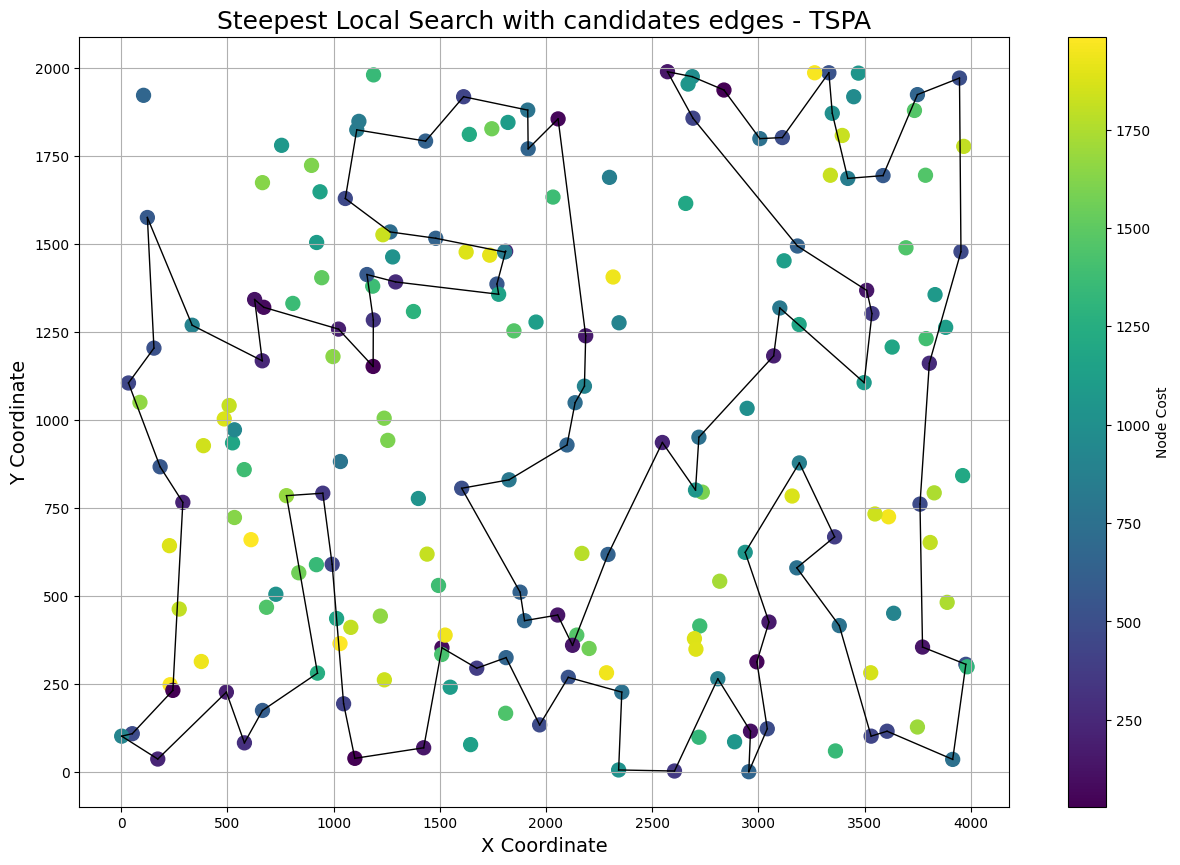

In [97]:
visualize_selected_route(best_solutions["A"][0], instances["A"], "Steepest Local Search with candidates edges - TSPA")

C:\Users\janko\AppData\Local\Temp\ipykernel_15124\3272644663.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


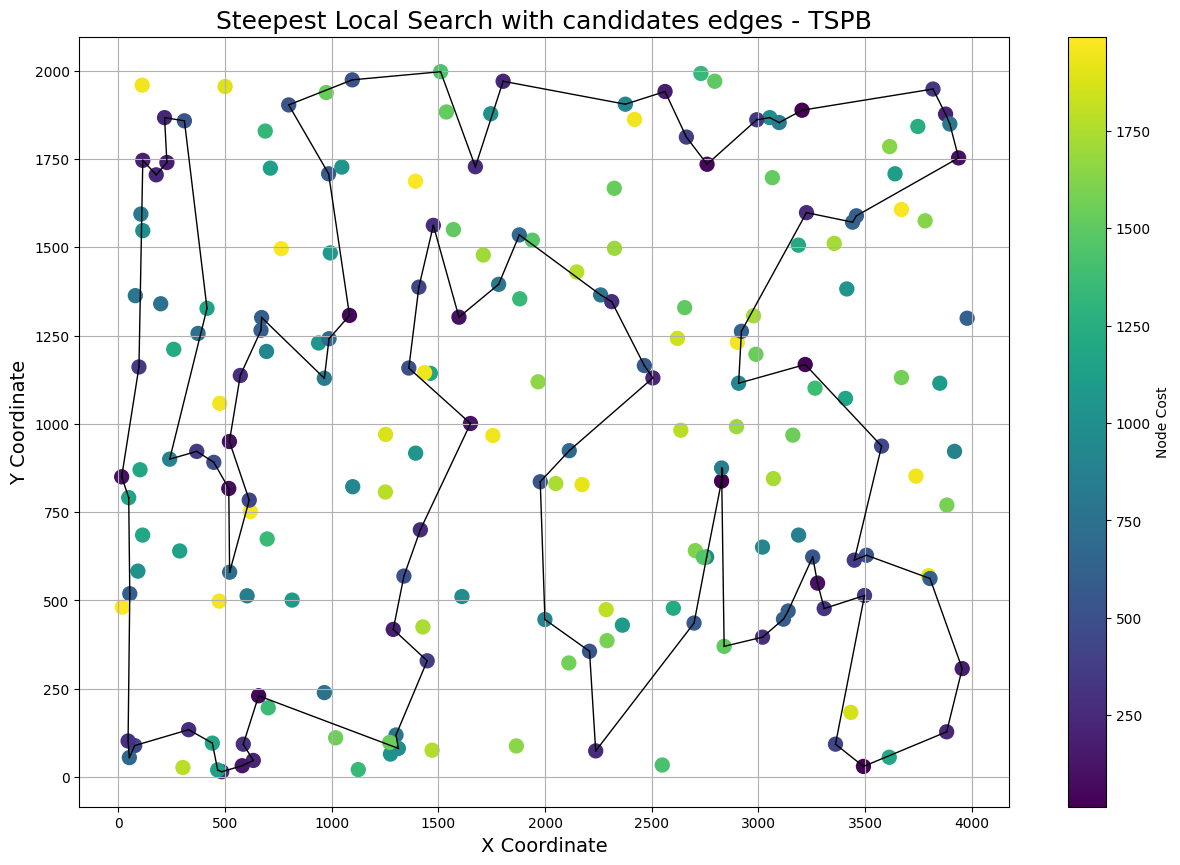

In [98]:
visualize_selected_route(best_solutions["B"][0], instances["B"], "Steepest Local Search with candidates edges - TSPB")

C:\Users\janko\AppData\Local\Temp\ipykernel_15124\3272644663.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


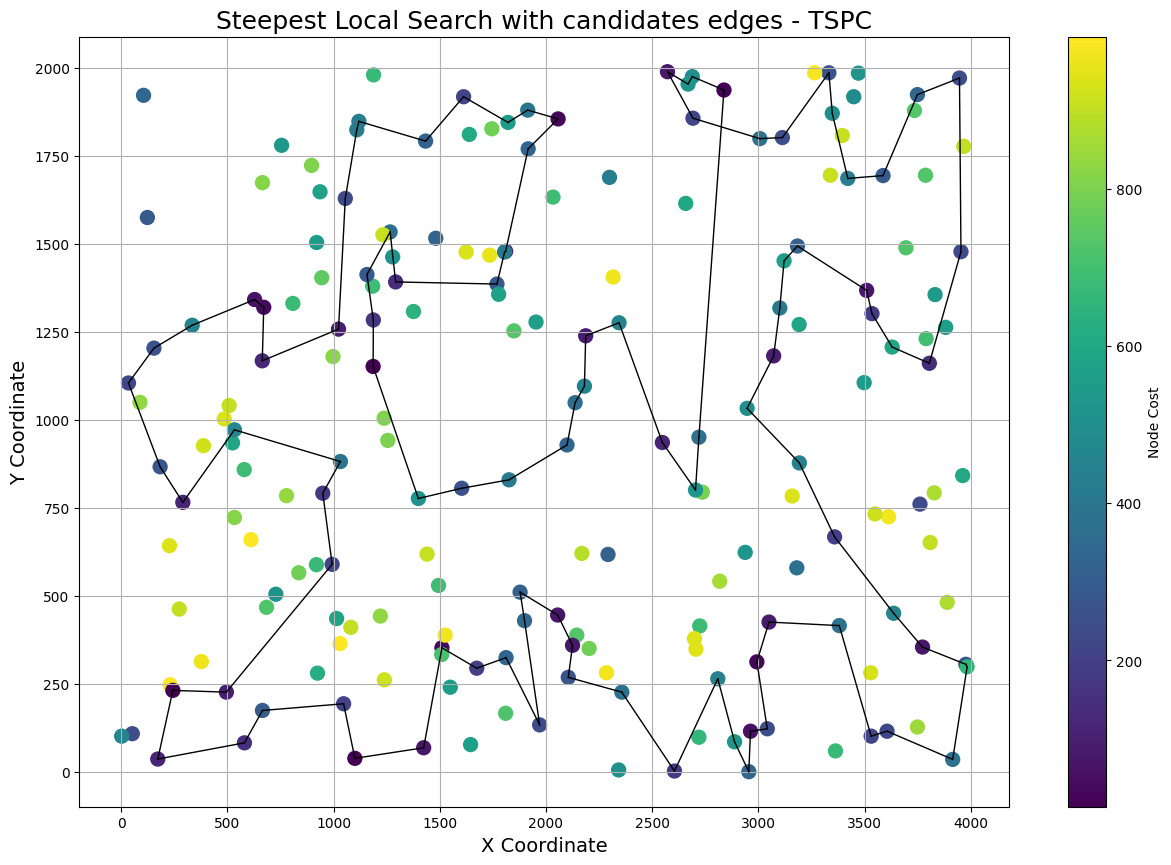

In [99]:
visualize_selected_route(best_solutions["C"][0], instances["C"], "Steepest Local Search with candidates edges - TSPC")

C:\Users\janko\AppData\Local\Temp\ipykernel_15124\3272644663.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


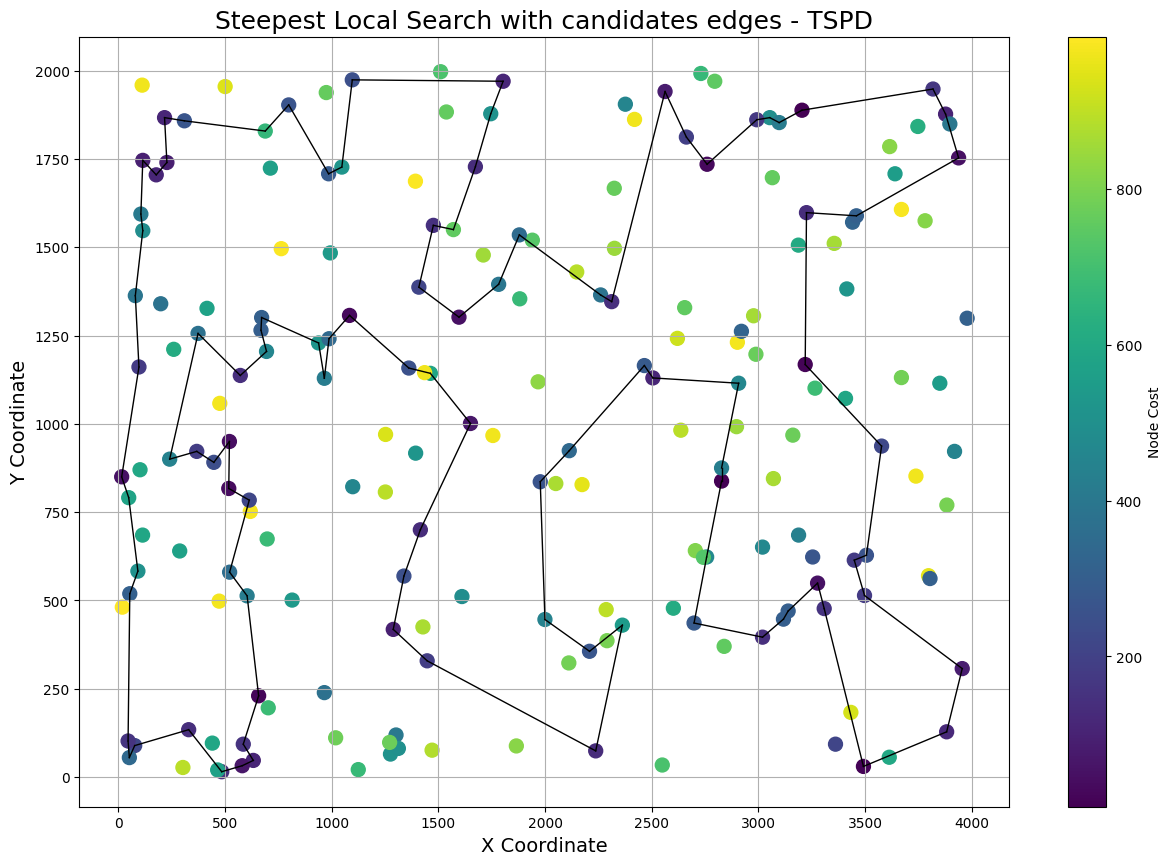

In [100]:
visualize_selected_route(best_solutions["D"][0], instances["D"], "Steepest Local Search with candidates edges - TSPD")